1. обучить несколько разных моделей на наборе данных ССЗ (train_case2.csv): логрег, бустинг, лес и т.д - на ваш выбор 2-3 варианта
2. при обучении моделей обязательно использовать кроссвалидацию

In [1]:
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from scipy.sparse import hstack
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, confusion_matrix, log_loss, plot_precision_recall_curve
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import StandardScaler
import itertools

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
def get_metrics(y_true, preds):
    precision, recall, thresholds = precision_recall_curve(y_true, preds)
    fscore = (2 * precision * recall) / (precision + recall)
    ix = np.argmax(fscore)
    print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                            fscore[ix],
                                                                            precision[ix],
                                                                            recall[ix]))
    return {'BestThreshold': thresholds[ix], 'fscore': fscore[ix], 'precision': precision[ix], 'recall': recall[ix]}

def plor_pr_curve(y_true, y_scores:list, curve_names=None):
    sns.set(font_scale=1.5)
    sns.set_color_codes("muted")

    plt.figure(figsize=(10, 8))
    if not curve_names:
        curve_names = [i for i, _ in enumerate(y_scores)]
    for score, name in zip(y_scores, curve_names):
        precision, recall, thresholds_ = precision_recall_curve(y_true, score)
        plot_precision_recall_curve(precision, recall)
        print(precision, recall)
        print(auc(precision, recall))
        plt.plot(precision, recall)#, label=f'{name} pr_score: {auc(precision, recall):.2f}')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('PR curve')
    #plt.legend()
    plt.show()

def plot_roc_auc(y_true, y_scores:list, curve_names=None):
    sns.set(font_scale=1.5)
    sns.set_color_codes("muted")

    plt.figure(figsize=(10, 8))
    if not curve_names:
        curve_names = [i for i, _ in enumerate(y_scores)]
    for score, name in zip(y_scores, curve_names):
        fpr, tpr, thresholds_ = roc_curve(y_true, score, pos_label=1)
        lw = 2
        plt.plot(fpr, tpr, lw=lw, label=f'{name} roc_auc: {roc_auc_score(y_true, score):.2f}')
        plt.plot([0, 1], [0, 1])
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend()
    plt.show()
    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [3]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in test_columns:
            if col_ not in self.columns:
                X[col_] = 0
        return X[self.columns]

In [4]:
df = pd.read_csv('train_case2.csv', ';')
X_train, X_test, y_train, y_test = train_test_split(df.drop('cardio', 1), df['cardio'], random_state=0)

continuos_cols = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']
cat_cols = ['gender', 'cholesterol']
base_cols = ['gluc', 'smoke', 'alco', 'active']

continuos_transformers = []
cat_transformers = []
base_transformers = []

for cont_col in continuos_cols:
    transfomer =  Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('standard', StandardScaler())
            ])
    continuos_transformers.append((cont_col, transfomer))
    
for cat_col in cat_cols:
    cat_transformer = Pipeline([
                ('selector', ColumnSelector(key=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    cat_transformers.append((cat_col, cat_transformer))
    
for base_col in base_cols:
    base_transformer = Pipeline([
                ('selector', NumberSelector(key=base_col))
            ])
    base_transformers.append((base_col, base_transformer))
    
feats = FeatureUnion(continuos_transformers+cat_transformers+base_transformers)

In [5]:
def fit_model(model, X_train, y_train):
    cv_scores = cross_val_score(model, X_train, y_train, cv=16, scoring='roc_auc')
    cv_score = np.mean(cv_scores)
    cv_score_std = np.std(cv_scores)
    print(f'CV score is {cv_score}+-{cv_score_std}')
    model.fit(X_train, y_train)
    y_score = model.predict_proba(X_test)[:, 1]
    return y_score

In [6]:
logistic_classifier = Pipeline([
    ('features',feats),
    ('classifier', LogisticRegression(random_state = 42)),
])

y_score_logreg = fit_model(logistic_classifier, X_train, y_train)

CV score is 0.7867401104915408+-0.00852135511666111


In [7]:
forest_classifier = Pipeline([
    ('features',feats),
    ('classifier', RandomForestClassifier(random_state = 42)),
])

y_score_forest = fit_model(forest_classifier, X_train, y_train)

CV score is 0.7734501681056019+-0.007171140345435727


In [8]:
boosting_classifier = Pipeline([
    ('features',feats),
    ('classifier', GradientBoostingClassifier(random_state = 42)),
])

y_score_boosting = fit_model(boosting_classifier, X_train, y_train)

CV score is 0.8025124517417064+-0.007075372179995901


3. вывести сравнение полученных моделей по основным метрикам классификации: pr/rec/auc/f_score (можно в виде таблицы, где строки - модели, а столбцы - метрики)

In [9]:
result_metrics = pd.DataFrame([get_metrics(y_test, y_score_logreg).values(), 
                               get_metrics(y_test, y_score_forest).values(),
                               get_metrics(y_test, y_score_boosting).values()], 
                               columns=['Threshold', 'F-Score', 'Precision', 'Recall'])
result_metrics['name'] = ['logreg', 'forest', 'boosting']
result_metrics

Best Threshold=0.386937, F-Score=0.730, Precision=0.647, Recall=0.838
Best Threshold=0.350000, F-Score=0.719, Precision=0.643, Recall=0.816
Best Threshold=0.394947, F-Score=0.740, Precision=0.698, Recall=0.788


,Threshold,F-Score,Precision,Recall,name
0,0.386937,0.730323,0.647431,0.837558,logreg
1,0.350000,0.718863,0.642669,0.815553,forest
2,0.394947,0.740248,0.697848,0.788134,boosting


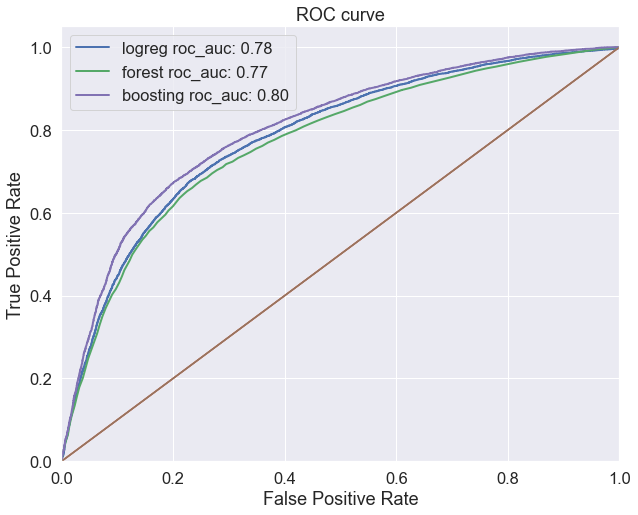

In [10]:
plot_roc_auc(y_test, [y_score_logreg, y_score_forest, y_score_boosting], curve_names=['logreg', 'forest', 'boosting'])

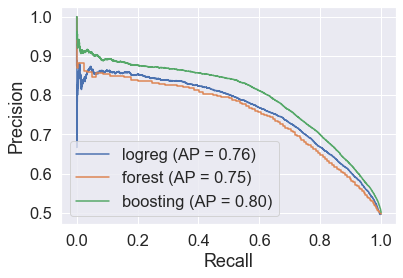

In [11]:
plot_precision_recall_curve(logistic_classifier, X_test, y_test, name='logreg',ax = plt.gca())
plot_precision_recall_curve(forest_classifier, X_test, y_test, name='forest',ax = plt.gca())
plot_precision_recall_curve(boosting_classifier, X_train, y_train, name='boosting',ax = plt.gca())

4. сделать выводы о том, какая модель справилась с задачей лучше других

In [12]:
def calc_rates(cnf_matrix):
    TN = cnf_matrix[0][0]
    FN = cnf_matrix[1][0]
    TP = cnf_matrix[1][1]
    FP = cnf_matrix[0][1]

    TPR = TP/(TP+FN)
    FPR = FP/(FP+TN)
    TNR = TN/(FP+TN)
    print(f'TPR:{TPR}, FPR:{FPR}, TNR:{TNR}')
    return TPR, FPR, TNR

Best Threshold=0.386937, F-Score=0.730, Precision=0.647, Recall=0.838
Confusion matrix, without normalization
[[4861 3959]
 [1411 7269]]


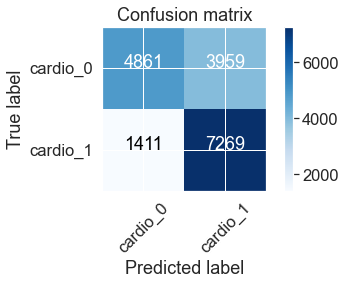

In [13]:
cnf_matrix = confusion_matrix(y_test, y_score_logreg>get_metrics(y_test, y_score_logreg)['BestThreshold'])
plot_confusion_matrix(cnf_matrix, classes=['cardio_0', 'cardio_1'], title='Confusion matrix')

In [14]:
log_reg_rates = calc_rates(cnf_matrix)

TPR:0.837442396313364, FPR:0.44886621315192743, TNR:0.5511337868480726


Best Threshold=0.350000, F-Score=0.719, Precision=0.643, Recall=0.816
Confusion matrix, without normalization
[[4991 3829]
 [1663 7017]]


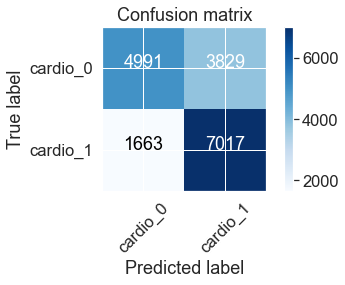

In [15]:
cnf_matrix = confusion_matrix(y_test, y_score_forest>get_metrics(y_test, y_score_forest)['BestThreshold'])
plot_confusion_matrix(cnf_matrix, classes=['cardio_0', 'cardio_1'], title='Confusion matrix')

In [16]:
forest_rates = calc_rates(cnf_matrix)

TPR:0.8084101382488479, FPR:0.43412698412698414, TNR:0.5658730158730159


Best Threshold=0.394947, F-Score=0.740, Precision=0.698, Recall=0.788
Confusion matrix, without normalization
[[5858 2962]
 [1840 6840]]


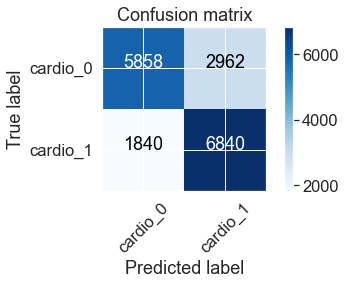

In [17]:
cnf_matrix = confusion_matrix(y_test, y_score_boosting>get_metrics(y_test, y_score_boosting)['BestThreshold'])
plot_confusion_matrix(cnf_matrix, classes=['cardio_0', 'cardio_1'], title='Confusion matrix')

In [18]:
boosting_rates = calc_rates(cnf_matrix)

TPR:0.7880184331797235, FPR:0.33582766439909295, TNR:0.664172335600907


In [19]:
result_metrics = pd.DataFrame([log_reg_rates, 
                               forest_rates,
                               boosting_rates], 
                               columns=['TPR', 'FPR', 'TNR'])
result_metrics['name'] = ['logreg', 'forest', 'boosting']
result_metrics

,TPR,FPR,TNR,name
0,0.837442,0.448866,0.551134,logreg
1,0.808410,0.434127,0.565873,forest
2,0.788018,0.335828,0.664172,boosting


Поскольку это задача определения потенциально больных людей, то желательно минимизировать количество тех у которых не будет найдена болезнь: FN. Из трех представленных моделей наилучший результат дает модель логистической регрессии (TPR=0,83).
Наилучшее качество по roc_auc и pr_auc дает модель градиентного бустинга, в данной задаче, это происходит за счет снижения TN предсказаний, но поскольку при этом данная модель имеет минимальный TPR это приводит к тому что у большего количества людей болезнь не будет найдена, следовательно эта модель наихудшая

5. (опциональный вопрос) какой график (precision_recall_curve или roc_auc_curve) больше подходит в случае сильного дисбаланса классов? (когда объектов одного из классов намного больше чем другого, например, 1 к 1000).
p.s.В вопросе проще разобраться, если вспомнить оси на графике roc auc curve и рассмотреть такой пример:

Имеется 100000 объектов, из которых только 100 - класс "1" (99900 - класс "0", соответственно).
Допустим, у нас две модели:

первая помечает 100 объектов как класс 1, но TP = 90
вторая помечает 1000 объектов как класс 1, но TP такой же - 90
Какая модель лучше и почему? И что позволяет легче сделать вывод - roc_auc_curve или precision_recall_curve?

In [20]:
import random

In [22]:
first_model = np.zeros(100000)
second_model = np.zeros(100000)
y_true = np.zeros(100000)
for i in range(100):
    choice = random.randint(0, len(y_true)+1)
    y_true[choice] = 1
    if i < 90:
        first_model[choice] = 1
        second_model[choice] = 1
        
first_preds = pd.DataFrame(first_model, columns=['pred',])
sec_preds = pd.DataFrame(second_model, columns=['pred',])

zero_indexes = sec_preds.loc[sec_preds['pred'] != 1][:990].index.to_list()
sec_preds.iloc[zero_indexes] = 1

In [23]:
first_preds.value_counts()

pred
0.0     99910
1.0        90
dtype: int64

In [24]:
sec_preds.value_counts()

pred
0.0     98920
1.0      1080
dtype: int64

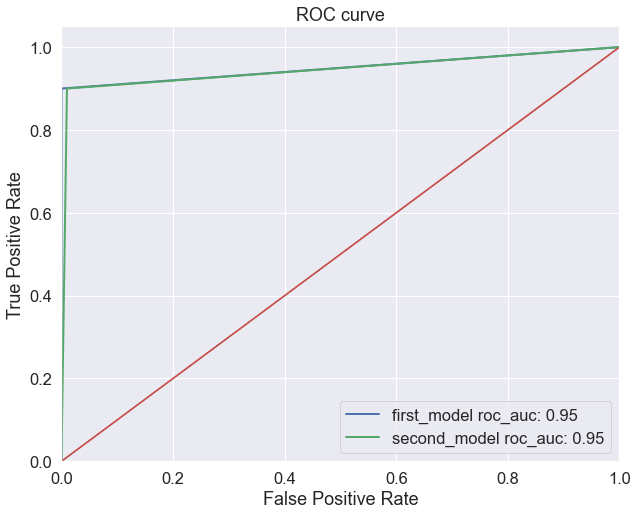

In [25]:
plot_roc_auc(y_true, [first_preds, sec_preds], ['first_model', 'second_model'])

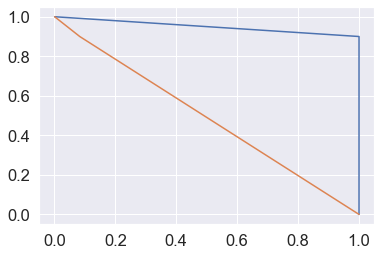

In [26]:
prec1, rec1, thr1 = precision_recall_curve(y_true, first_preds)
prec2, rec2, thr2 = precision_recall_curve(y_true, sec_preds)
plt.plot(prec1, rec1)
plt.plot(prec2, rec2)

В случае дисбаланса классов PR-кривая показывает разницу между моделями более наглядно